# Ramsey model with housing and a government sector

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `ramsey_thje.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [14]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject
import ramsey_thje

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

In this model project, we extend the Ramsey model to include a housing market. In the first iteration, we solve the model assuming that housing supply is in fixed supply and that the housing stock does not depreciate over time. Most of the model is as described in the lecture notebook on the Ramsey model. Our changes to the mode are marked in <span style="color:red"> *red*</span>.

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** Single infinitely-lived household.

**Household:** Households choose non-durable consumption, $C_t$ and durable housing $H_t$ such as to maximize discount lifetime utility. Labor is supplied exogenously, $N_{t}=1$, and earns a wage $w_{t}$. The return on saving is $r_{t+1}$. Utility is CRRA and given by: 

$$
\begin{aligned}
	U & =\max_{\{C_{t},\color{red}H_{t}, A_t\color{black}\}_{t=0}^{\infty}}\sum_{t=0}^{\infty}\beta^{t}\left(\frac{C_{t}^{1-\sigma}}{1-\sigma}\color{red}+\upsilon\frac{H_{t}^{1-\sigma_h}}{1-\sigma_h}\color{black}\right),\beta\in(0,1),\sigma>0\\
	& \text{s.t.}\\
	A_{t}+C_t+\color{red}q_tH_t\color{black}& =(1+r_{t})A_{t-1}+w_{t}N_{t} + \color{red}(q_{t}-\tau^H_t)H_{t-1}\color{black}
\end{aligned}
$$

where the left hand side of the budget constraint is expenditures on saving, consumption and housing. The right hand side is what is carried over in savings from last period, labor income and the amount of housing held from the last period. $\tau^H_t$ is a lump-sum tax paid per unit of housing. In this first iteration, we assume that government spending and privat consumption is seperable. This is also sometimes called wasteful government sepending because it only changes the level of utility, but not FOCs. For our current purposes, this implies that we do not explicitly need to model, what the government spending is used for. 

**Firms:** Firms rent capital $K_{t-1}$ at the rental rate $r_{t}^{K}$
and hires labor $L_{t}$ at the wage rate $w_{t}$.<br>
Firms have access to the production function
    
$$
\begin{aligned}
Y_{t} &= F(K_{t-1},L_{t}) \\ &=\Gamma_t(\alpha K_{t-1}^{-\theta}+(1-\alpha)L_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1),\Gamma_t>0
\end{aligned}
$$

Profits are

$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}L_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Government**: To keep things very simple, we assume that the government is not allowed to borrow nor save, and that the budget will always be balanced. In this case, government consumption will be given by: 

$$
G_t = \tau^H_t \bar{H},
$$
where we use the fact that the housing stock is fixed over time.

**Equilibrium:** The following conditions will be satisfied in equilibrium

1. Households maximize utility
2. Firms maximize profits
3. Labor market clear: $L_{t}=N_{t}=1$
4. Goods market clear: $Y_{t}=C_{t}+I_{t}$
5. <span style="color:red"> Housing market clear:</span> $\color{red} \bar{H}=H_t$
6. Asset market clear: $A_{t}=K_{t}$ and $r_{t}=r_{t}^{k}-\delta$
7. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

**Solution**: We can summarize the model in the non-linear equation system

$$
\begin{aligned}
\boldsymbol{\Psi}(\boldsymbol{K},\boldsymbol{C}, \color{red} \boldsymbol{q}\color{black},K_{-1})=\left[\begin{array}{c}
\Psi_{0}\\
\Psi_{1}\\
\begin{array}{c}
\vdots\end{array}
\end{array}\right]=\left[\begin{array}{c}
0\\
0\\
\begin{array}{c}
\vdots\end{array}
\end{array}\right]
\end{aligned}
$$

where $\boldsymbol{K} = [K_0,K_1\dots]$, $\boldsymbol{C} = [C_0,C_1\dots]$,  $\color{red}\boldsymbol{q} = [q_0,q_1\dots]$ and

$$
\begin{aligned}
\Psi_{t}
=\left[\begin{array}{c}
C_{t}^{-\sigma}-\beta(1+F_{K}(K_{t},1))C_{t+1}^{-\sigma}\\
K_{t}-[(1-\delta)K_{t-1} + F(K_{t-1},1)-C_{t}] \\
\color{red} \bar{H}^{-\sigma_h} + \beta C_{t+1}^{-\sigma}(q_{t+1}-\tau_{t+1}^H) - C_t^{-\sigma}q_t
\end{array}\right],
\end{aligned}
$$

where the last equation is derived by combining the FOC for housing demand with the assumption of fixed housing supply.

## Analytical solution (steady state)

In addition to the code in the lectures, we have to solve for the steady state level of housing prices in the economy. To do this, we use our Euler equation for the housing market and the fact that in steady state $C_{t+1}=C_{t}=C_{ss}$. Using this, we can write: 

$$
q^{ss} = \frac{1}{1-\beta}\frac{\upsilon\bar{H}^{-\sigma_h}-\tau^H_{ss}\beta C^{-\sigma}_{ss}}{C^{-\sigma}_{ss}}
$$

## Numerical solution

We solve the model using the Broyden solver presented in the lecture slides. 

**Initializing the model and creating an instance of class**:

In [2]:
model = ramsey_thje.RamseyModelClass()
par = model.par
ss = model.ss
path = model.path

initializing the model:
calling .setup()
calling .allocate()


**Finding the steady state of the model**:

In [3]:
model.find_steady_state(KY_ss=4.0)

Y_ss = 1.0000
C_ss = 0.8000
q_ss = 50.4800
K_ss/Y_ss = 4.0000
rk_ss = 0.0750
r_ss = 0.0250
w_ss = 0.7000
Gamma = 0.6598
beta = 0.9756


**Checking that there are no errors in steady state**:

In [4]:
# a. set initial value
par.K_lag_ini = ss.K

# b. set path
path.Gamma[:] = ss.Gamma
path.tauH[:] = ss.tauH
path.C[:] = ss.C
path.K[:] = ss.K
path.q[:] = ss.q

# c. check errors
errors_ss = model.evaluate_path_errors()
assert np.allclose(errors_ss,0.0)

**Solving the model.** In the following piece of code, we show that the model *does not* converge for all initial starting values of capital. In particular for values below ~10% of initial capital stock. Note that the following code will raise some errors because the errors returns nans. We have solved the problem of the code crashing by using a try-except clause. We do like this to illutrate the point, but allowing the code to run smoothly.

In [5]:
model.calculate_jacobian()
init_val_list = np.linspace(1e-8,0.95,10)
K_init_val = np.nan + np.zeros([len(path.K), len(init_val_list)])
C_init_val = np.nan + np.zeros([len(path.C), len(init_val_list)])
q_init_val = np.nan + np.zeros([len(path.q), len(init_val_list)])

# a. solve for differnet starting points
for init_val_idx, init_val in enumerate(init_val_list):
    try:
        par.K_lag_ini = init_val*ss.K
        model.solve(do_print = False)
        K_init_val[:,init_val_idx] = path.K
        C_init_val[:,init_val_idx] = path.C
        q_init_val[:,init_val_idx] = path.q
    except:
        print(f"Could not solve for init_val = {init_val}")

Could not solve for init_val = 1e-08


/Users/mikkellyngholm/Desktop/projects-2024-mikkel-thomas/modelproject/ramsey_thje.py:242: RuntimeWarning: invalid value encountered in power
  Y = Gamma*K_lag**par.alpha * (1.0)**(1-par.alpha)
/Users/mikkellyngholm/Desktop/projects-2024-mikkel-thomas/modelproject/ramsey_thje.py:245: RuntimeWarning: invalid value encountered in power
  rk = Gamma*par.alpha * K_lag**(par.alpha-1) * (1.0)**(1-par.alpha)
/Users/mikkellyngholm/Desktop/projects-2024-mikkel-thomas/modelproject/ramsey_thje.py:246: RuntimeWarning: invalid value encountered in power
  w = Gamma*(1-par.alpha) * K_lag**(par.alpha) * (1.0)**(-par.alpha)


Could not solve for init_val = 0.10555556444444443


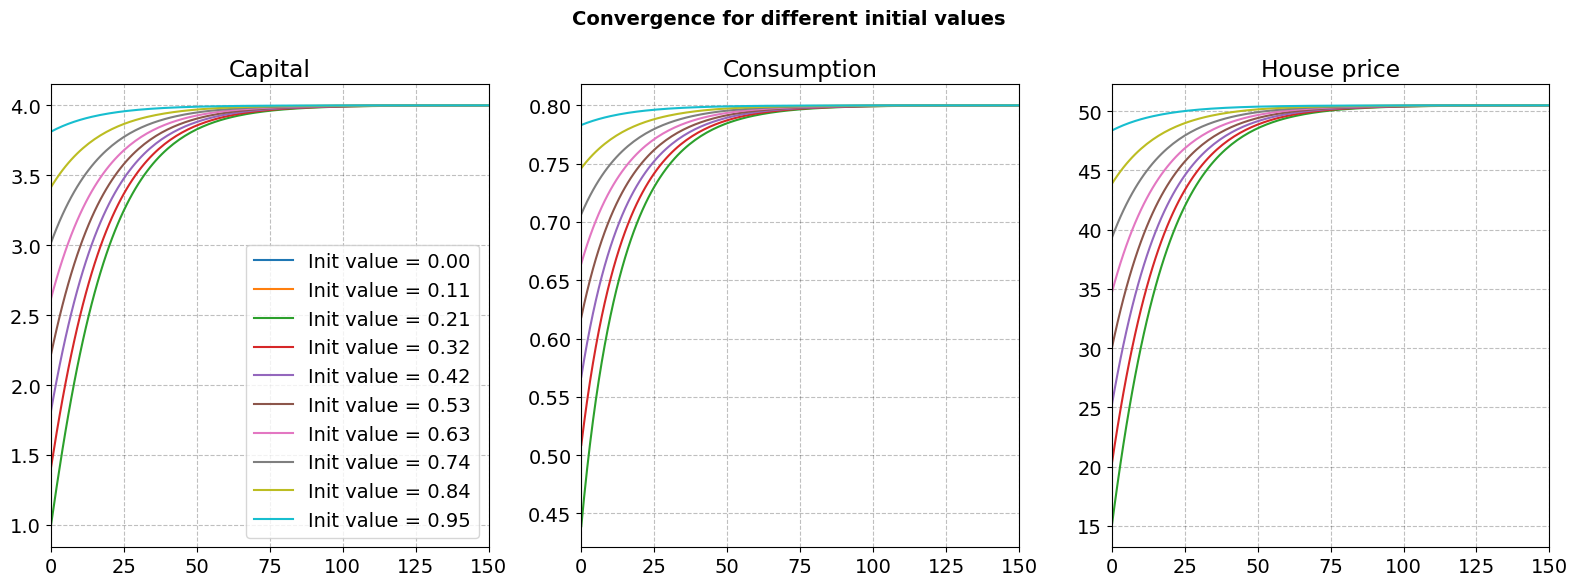

In [6]:
fig = plt.figure(figsize=(16,6))

fig.suptitle('Convergence for different initial values', fontsize=14, fontweight='bold')
ax = fig.add_subplot(1,3,1)
for init_val_idx, init_val in enumerate(init_val_list):
    ax.plot(K_init_val[:,init_val_idx],label=f'Init value = {init_val:.2f}')
ax.legend(frameon=True)
ax.set_title('Capital')
ax.set_xlim([0, 150])
fig.tight_layout()

ax = fig.add_subplot(1,3,2)
for init_val_idx, init_val in enumerate(init_val_list):
    ax.plot(C_init_val[:,init_val_idx],label=f'Init value = {init_val:.2f}')
ax.set_title('Consumption')
ax.set_xlim([0, 150])
fig.tight_layout()

ax = fig.add_subplot(1,3,3)
for init_val_idx, init_val in enumerate(init_val_list):
    ax.plot(q_init_val[:,init_val_idx],label=f'Init value = {init_val:.2f}')
ax.set_title('House price')
ax.set_xlim([0, 150])
fig.tight_layout()

## Shocks to the model

### Shock 1: Positive productivity shock

Our first shock to the model is a transitory shock to the productivity. We show a so-called "MIT" shock meaning it's a 1-time unexpected shock and that agents have perfect foresigth about the future of the economy (and don't expect additional shocks)

In [7]:
par.K_lag_ini = ss.K # start from steady state
path.Gamma[:] = ss.Gamma 
path.tauH[:] = ss.tauH
path.Gamma[:] = 0.95**np.arange(par.Tpath)*0.1*ss.Gamma + ss.Gamma # shock path
model.solve() # find transition path

 it =   0 -> max. abs. error =   0.10000000
 it =   1 -> max. abs. error =   0.01883938
 it =   2 -> max. abs. error =   0.00367471
 it =   3 -> max. abs. error =   0.00032824
 it =   4 -> max. abs. error =   0.00002626
 it =   5 -> max. abs. error =   0.00000146
 it =   6 -> max. abs. error =   0.00000035
 it =   7 -> max. abs. error =   0.00000003
 it =   8 -> max. abs. error =   0.00000000


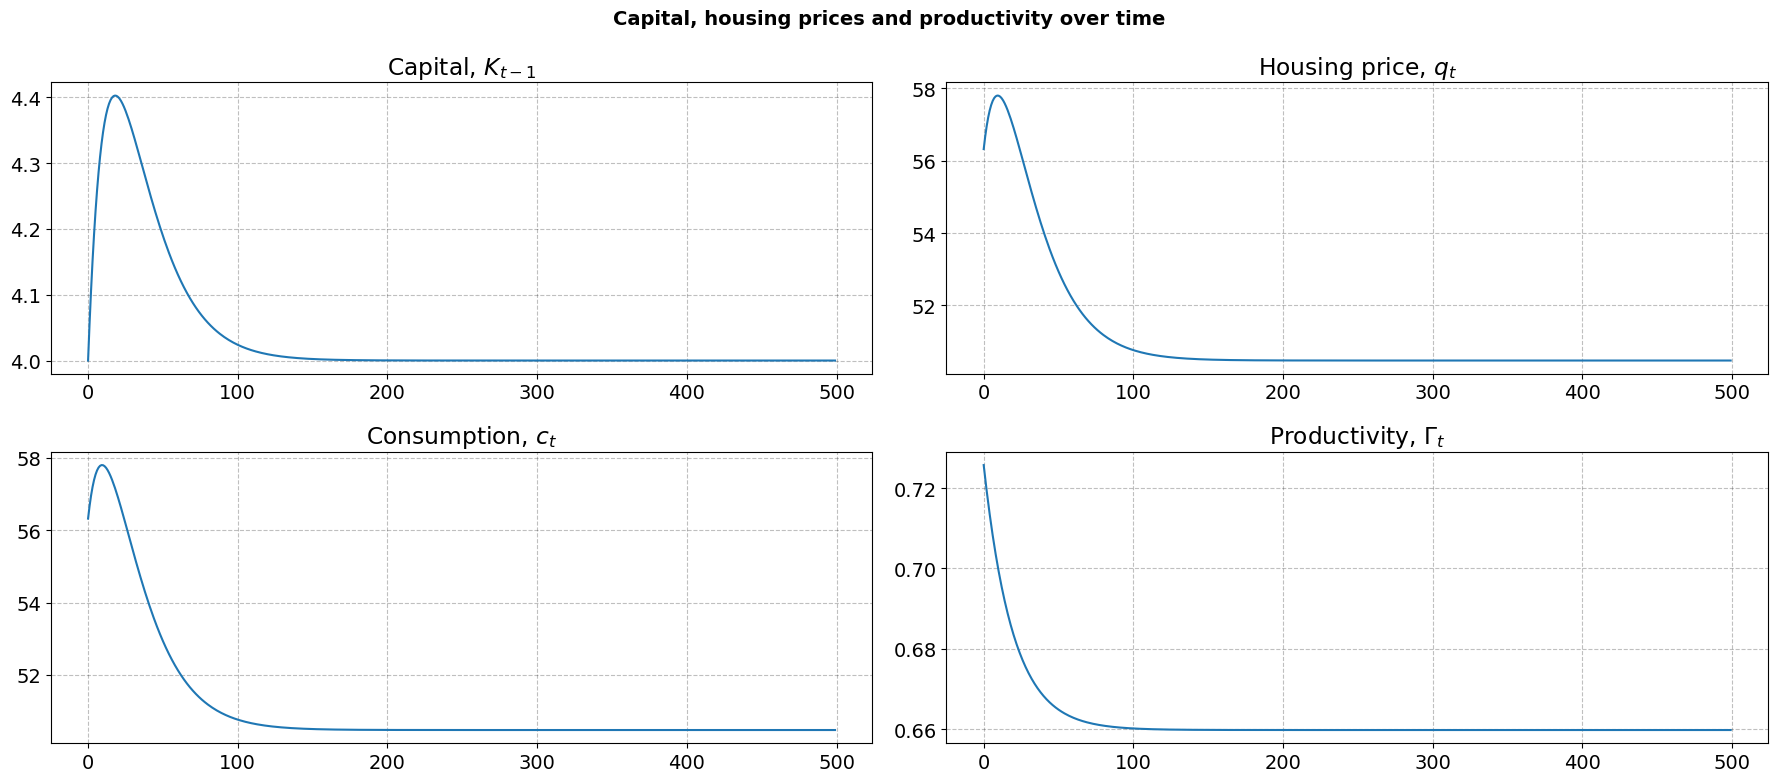

In [8]:
fig = plt.figure(figsize=(3*6,12/1.5))
fig.suptitle('Capital, housing prices and productivity over time', fontsize=14, fontweight='bold')
ax = fig.add_subplot(2,2,1)
ax.set_title('Capital, $K_{t-1}$')
ax.plot(path.K_lag)

ax = fig.add_subplot(2,2,2)
ax.plot(path.q)
ax.set_title('Housing price, $q_{t}$')

ax = fig.add_subplot(2,2,3)
ax.plot(path.q)
ax.set_title('Consumption, $c_{t}$')

ax = fig.add_subplot(2,2,4)
ax.plot(path.Gamma)
ax.set_title('Productivity, $\Gamma_{t}$')

fig.tight_layout()

### Shock 2.1: Transitory increase in housing taxes

In [9]:
tauH_new = 0.1
tax_end = 50

par.K_lag_ini = ss.K # start from steady state
path.Gamma[:] = ss.Gamma 
path.tauH[:] = ss.tauH # reset path
path.tauH[10:tax_end] = tauH_new
# path.Gamma[:] = 0.95**np.arange(par.Tpath)*0.1*ss.Gamma + ss.Gamma # shock path
model.solve() # find transition path

 it =   0 -> max. abs. error =   0.07621951
 it =   1 -> max. abs. error =   0.00000001


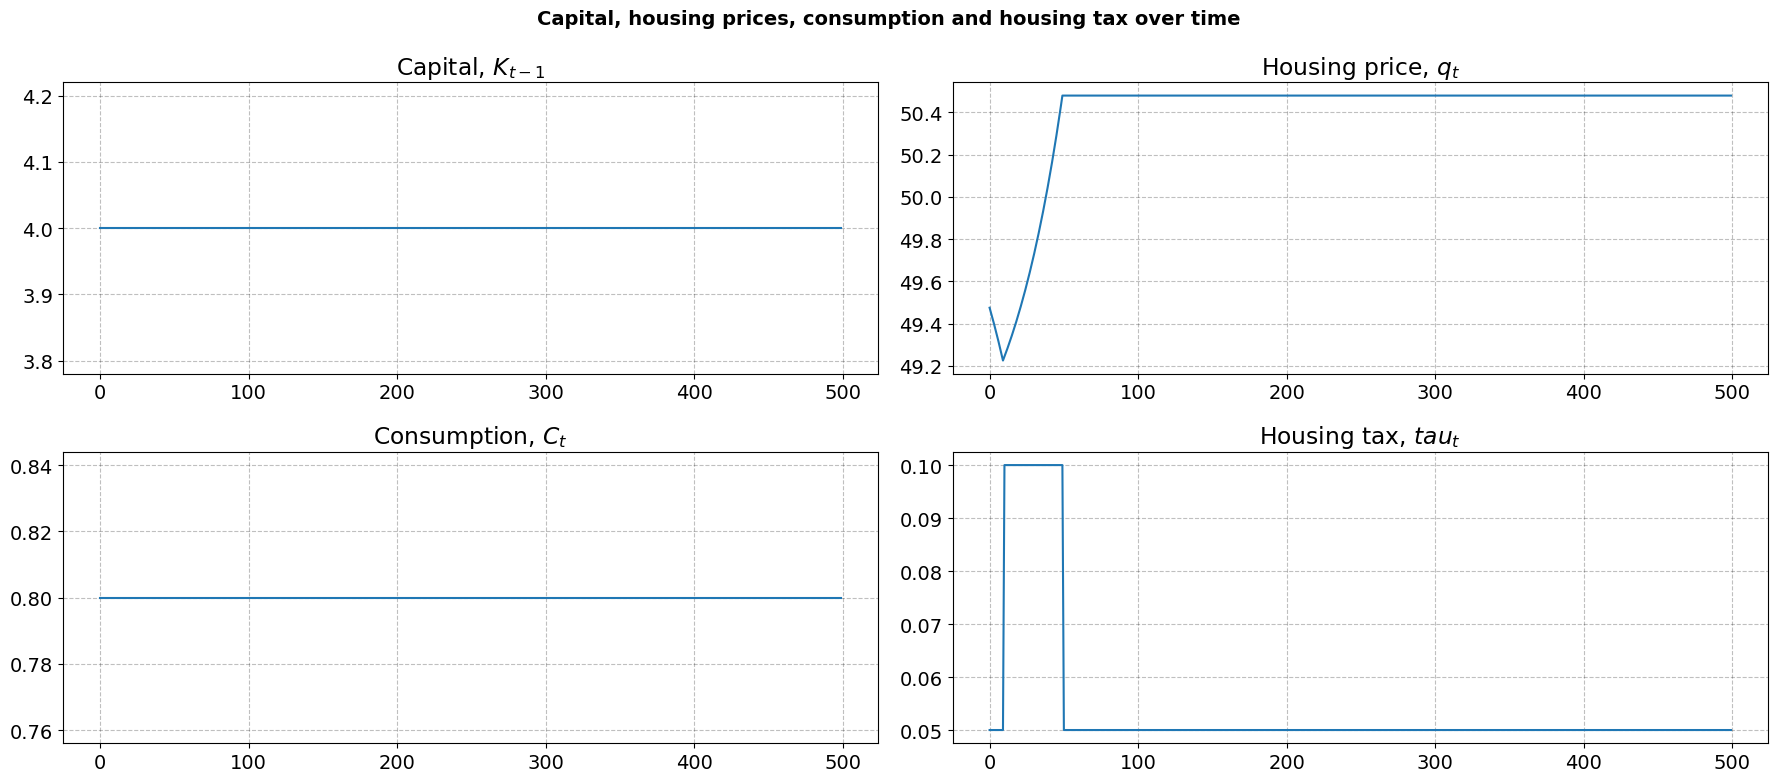

In [10]:
fig = plt.figure(figsize=(3*6,12/1.5))
fig.suptitle('Capital, housing prices, consumption and housing tax over time', fontsize=14, fontweight='bold')
ax = fig.add_subplot(2,2,1)
ax.set_title('Capital, $K_{t-1}$')
ax.plot(path.K_lag)

ax = fig.add_subplot(2,2,2)
ax.plot(path.q)
ax.set_title('Housing price, $q_{t}$')

ax = fig.add_subplot(2,2,3)
ax.plot(path.C)
ax.set_title('Consumption, $C_{t}$')

ax = fig.add_subplot(2,2,4)
ax.plot(path.tauH)
ax.set_title('Housing tax, $tau_{t}$')

fig.tight_layout()

It is seen that change in the housing tax makes the house price drop before it is seen implemented. Furthermore it is seen that the change it housing price does not affect consumption. FYI, we're not a 100% sure whether it's a bug that consumption and capital is not affected. 

# Further analysis

In [11]:
model = ramsey_thje.RamseyModelClass(do_print = False)
par = model.par
ss = model.ss
path = model.path

upsilon_list = np.linspace(0.1,3.0,15)
tauH_list = np.linspace(0.0,1.0,15)

ss_matrix = np.nan + np.zeros([len(upsilon_list), len(tauH_list)])

model = ramsey_thje.RamseyModelClass()
par = model.par
ss = model.ss
path = model.path
for upsilon_idx, upsilon in enumerate(upsilon_list):
    for tauH_idx, tauH in enumerate(tauH_list):
        par.upsilon = upsilon
        par.tauH = tauH

        model.find_steady_state(KY_ss=4.0, do_print=False)
        ss_matrix[upsilon_idx, tauH_idx] = ss.q
        # print(f"upsilon = {upsilon:.2f}, tauH = {tauH:.2f}, q = {ss.q:.2f}")

initializing the model:
calling .setup()
calling .allocate()


In [12]:
ss_matrix[2, :]

array([ 13.49485714,  10.63771429,   7.78057143,   4.92342857,
         2.06628571,  -0.79085714,  -3.648     ,  -6.50514286,
        -9.36228571, -12.21942857, -15.07657143, -17.93371429,
       -20.79085714, -23.648     , -26.50514286])

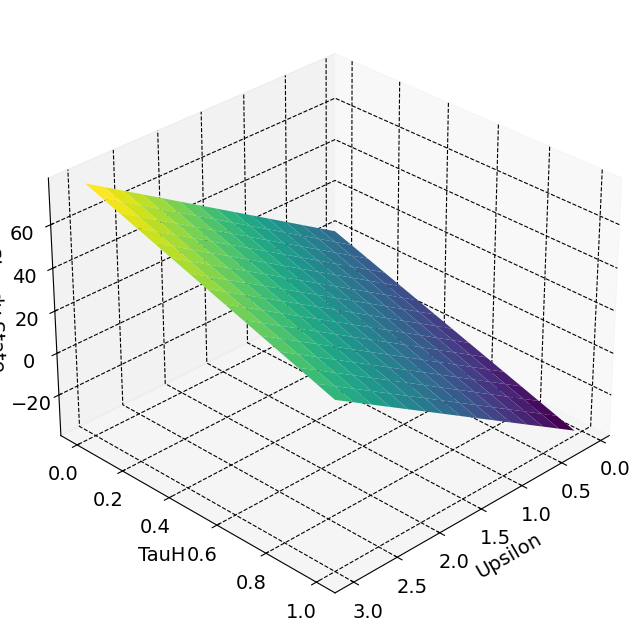

In [13]:
# Create a meshgrid for upsilon and tauH
upsilon_mesh, tauH_mesh = np.meshgrid(upsilon_list, tauH_list)

# Create a 3D plot
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(upsilon_mesh, tauH_mesh, ss_matrix.T, cmap='viridis')

# Add labels
ax.set_xlabel('Upsilon')
ax.set_ylabel('TauH')
ax.set_zlabel('Steady State')
ax.view_init(30, 45)

# Show the plot
plt.show()

We see in this plot that a higher preference for housing, $\upsilon$ and lower tax $\tau^H$ increase the housing price as expected.

# Extensions of the model before the exam

We have not really had time to extend the model more before deadline for hand-in. However before the exam, we intend to do more work on the model. This includes potentially making housing a factor in the production function, and through there do such that a change in the housing tax will affect capital and consumption. Potentially we could also make housing and consumption non-seperable

# Conclusion

In this assignment, we have seen that house prices decrease when housing taxes go up. We have also seen that this happens even before the tax have been implemented due to the fact that agents are forward-looking.